In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

## Dependencies

In [2]:
from functools import partial
from itertools import product
from copy import deepcopy
import typing
import time
import sys
import pickle
import os

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import benchmark, GenericOuterHook, PredictionErrorHook
from mazelab_experimenter.utils import compute_optimal_value


# Result output format.
FILE_FORMAT = 'pdf'
OUTPUT_FORMAT = 'figures/ablation_{}.' + FILE_FORMAT

print("Output figures will be formatted as:", OUTPUT_FORMAT.format("FILENAME"))

Output figures will be formatted as: figures/ablation_FILENAME.pdf


## Environment Definition

We explore simple gridworld environments presenting tabular features to the agents. We test our agents on an empty world and on a world with rooms, we keep the dimensionality small due to memory requirements incurred by either the hindsight tables or eligibility trace models.

The agents/ environments are initialized with a binary reward function, i.e., a function that always returns $0$ until a desired state is reached upon which it returns $1$.

In [3]:
t = 10_000  # Number of steps before terminating an episode for any agent on all environments.

name_grid10 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

name_grid20 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=22, width=22),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[20, 20]]
    ),
    time_limit=t,
    override=True
)

name_rooms4 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=4, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[7, 7]]
    ),
    time_limit=t,
    override=True
)

name_rooms9 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[13, 13]]
    ),
    time_limit=t,
    override=True
)

name_mazeS = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=False),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[11, 11]]
    ),
    time_limit=t,
    override=True
)

name_mazeL = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=True),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[19, 19]]
    ),
    time_limit=t,
    override=True
)

# Collect each individual environment.
environment_names = [name_grid10, name_grid20, name_rooms4, name_rooms9, name_mazeS, name_mazeL]
environment_labels = ['10x10 Gridworld', '20x20 Gridworld', '4-rooms 5-to-1', '9-rooms 5-to-1', '10x10 Maze', '20x20 Maze']
environment_optimum = [18, 38, 16, 28, 20, 36]

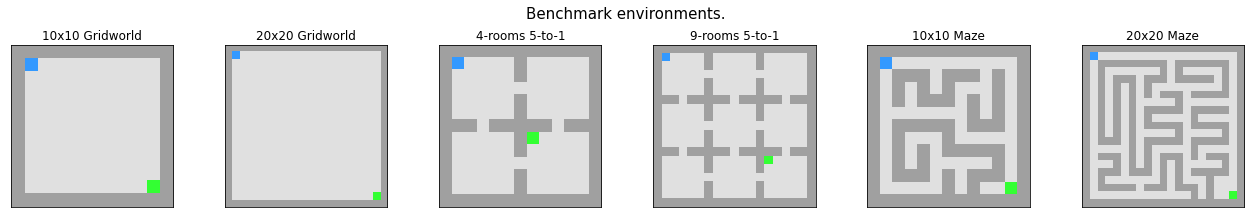

In [4]:
# Create and show an example visualization of the environment
dummy_images = list()
for name in environment_names:
    dummy = gym.make(name)
    dummy.reset()
    
    dummy_images.append(dummy.unwrapped.get_image())
    dummy.close()
    
fig, ax = plt.subplots(1, len(environment_names), figsize=(3 * len(environment_names), 3))
for i, img in enumerate(dummy_images):
    # Plot image with border padding
    ax[i].imshow(img)
    
    # Remove grid lines
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    # Annotations
    ax[i].set_title(environment_labels[i])

plt.suptitle("Benchmark environments.", fontsize=15)
plt.savefig(OUTPUT_FORMAT.format('BenchmarkEnvironment', FILE_FORMAT), format=FILE_FORMAT, bbox_inches="tight")

plt.tight_layout()
plt.show()

# Visualize Performance Experiment

Data Structure:
- list of benchmark data for each environment:
    -> Dictionary with tags: 'name', 'meta', 'data', 'separators'.
       - 'name': str = Environment Name
       - 'meta': list = List of agent configurations in the benchmark ablations.
       - 'data': list = List of benchmark data per configuration in 'meta' (according to the common index).
       - 'separators': list = List of integers indicating the parameter-grid size of each consecutive experiment:
                              e.g., if 2 agent ablations were performed and stored in 'data'/ 'meta', the index 
                              separating the first and second ablation-grid is 'separator'[0].
                            

In [4]:
folder = 'results/ablations/default100k/flat_training/'

benchmark_data = list()
for e in environment_names:  # The Large environments
    print(e)
    l = [x for x in os.listdir(folder) if e in x]
    if l:
        n = folder + l[-1]
        print(n)
        with open(n, 'rb') as f:
            benchmark_data += pickle.load(f)

gridworld-v0
results/ablations/default100k/flat_training/flat_training_t100kperformance_ablation_gridworld-v0_1642606370.out
gridworld-v1
results/ablations/default100k/flat_training/flat_training_t100kperformance_ablation_gridworld-v1_1642711072.out
n_rooms-v0
results/ablations/default100k/flat_training/flat_training_t100kperformance_ablation_n_rooms-v0_1642621336.out
n_rooms-v1
results/ablations/default100k/flat_training/flat_training_t100kperformance_ablation_n_rooms-v1_1642788163.out
maze-v0
results/ablations/default100k/flat_training/flat_training_t100kperformance_ablation_maze-v0_1642648965.out
maze-v1
results/ablations/default100k/flat_training/flat_training_t100kperformance_ablation_maze-v1_1642915293.out


In [6]:
def get_timeseries(data_list):
    return [np.asarray(x)[..., -1][..., 0] for x in data_list]

In [10]:
print("Data Statistics:")
[(x['name'], np.asarray(x['data']).shape) for x in benchmark_data]

Data Statistics:


[('gridworld-v0', (32, 200, 50, 1, 3)),
 ('gridworld-v1', (32, 200, 50, 1, 3)),
 ('n_rooms-v0', (32, 200, 50, 1, 3)),
 ('n_rooms-v1', (32, 200, 50, 1, 3)),
 ('maze-v0', (32, 200, 50, 1, 3)),
 ('maze-v1', (32, 200, 50, 1, 3))]

# Parameter AUC

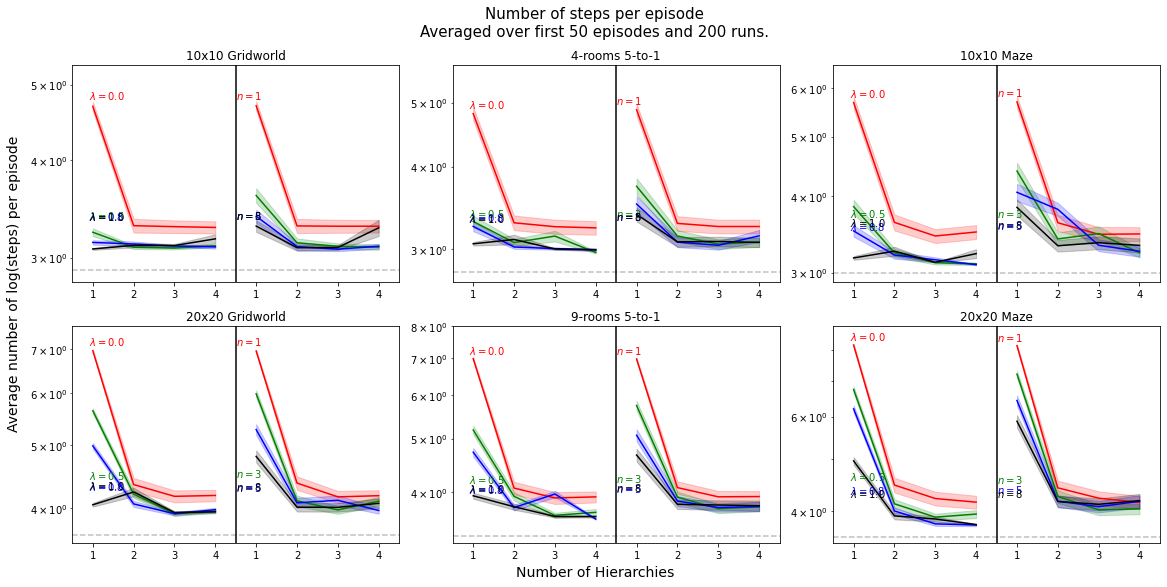

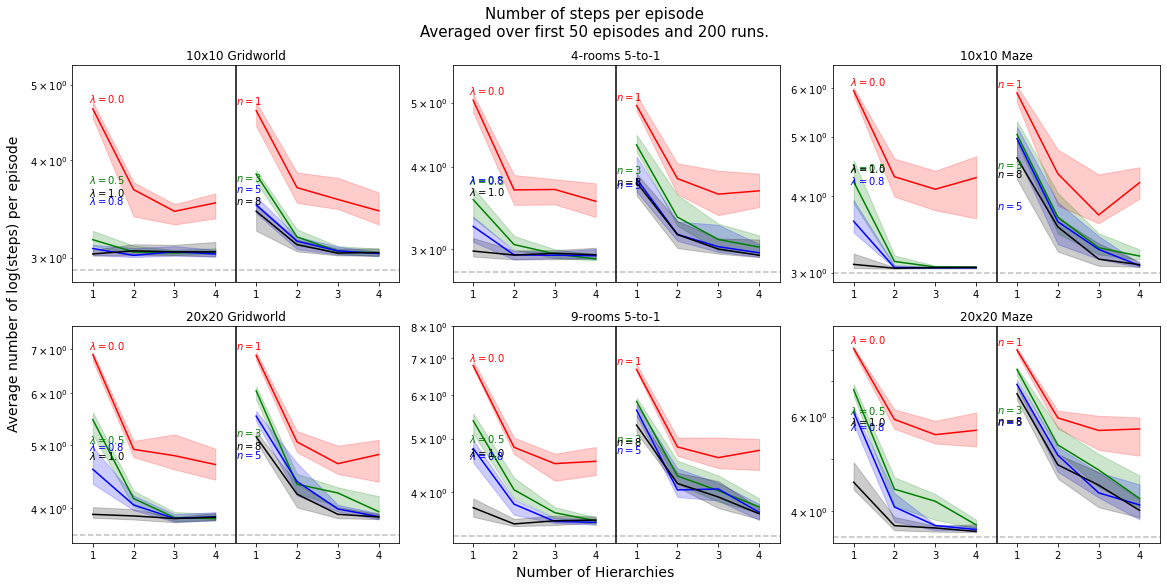

In [11]:
def mean_and_stderr(X):
    # X is of shape (configuration_i, episode_j, trial_k)
    mus = variance_stabilizer(X.mean(axis=1))  # Average over trials to get scores for: (configuration_i, avg_episode_j)
    mus = mus[..., :len(mus) - episode_subsample]
    
    mean = mus.mean(axis=-1)
    stderr = mus.std(axis=-1) / np.sqrt(mus.shape[-1])
    return mean, mean - stderr / 2, mean + stderr / 2
    
    
def quantiles(X, middle: float = 0.5, alpha: float = 0.3):
    mus = variance_stabilizer(X.mean(axis=-1))
    mus = mus[..., :len(mus) - episode_subsample]
    m, l, r = middle * 100, alpha * 100, 100 - alpha * 100
    
    return np.percentile(mus, q=m, axis=-1), np.percentile(mus, q=l, axis=-1), np.percentile(mus, q=r, axis=-1)
    
    
def process_plot_data(ablation_data, ablation_metadata, statistics, aggregator = mean_and_stderr):
    # Variable to condition the marginalized ablation data on.
    hierarchy_n, decays, n_steps = statistics
    
    # Data Structure to collect plot-data through marginalization of all ablations.
    plot_data = {
        'points': {i: {'decay': [0.0] * len(decays), 'n_steps': [0.0] * len(n_steps)} for i in range(hierarchy_n)},
        'error_low': {i: {'decay': [0.0] * len(decays), 'n_steps': [0.0] * len(n_steps)} for i in range(hierarchy_n)},
        'error_high': {i: {'decay': [0.0] * len(decays), 'n_steps': [0.0] * len(n_steps)} for i in range(hierarchy_n)}
    }
    
    alpha, beta_low, beta_high = aggregator(ablation_data)
    for i, p in enumerate(ablation_metadata):
        option = 'decay' if 'decay' in p else 'n_steps'
        option_stats = decays if 'decay' in p else n_steps
        
        pts_list = plot_data['points'][p['n_levels'] - 1][option]
        err_low_list = plot_data['error_low'][p['n_levels'] - 1][option]
        err_high_list = plot_data['error_high'][p['n_levels'] - 1][option]
    
        pts_list[option_stats.index(p[option])] += alpha[i]
        err_low_list[option_stats.index(p[option])] += beta_low[i]
        err_high_list[option_stats.index(p[option])] += beta_high[i]
    
    return plot_data['points'], plot_data['error_low'], plot_data['error_high']
    

def generate_figure(aggr_option: str = 'mean_and_stderr', annotate: bool = True):
    aggr_functions = {
        'mean_and_stderr': mean_and_stderr,
        'quantiles': quantiles
    }
    
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize=(16, 8))

    for env_i, env_data in enumerate(benchmark_data):
        # Environment data for generating the graphs.
        ablation_metadata = env_data['meta']

        hierarchy_n = max([m['n_levels'] for m in ablation_metadata])
        decays = sorted(list({x['decay'] for x in ablation_metadata if 'decay' in x}))
        n_steps = sorted(list({x['n_steps'] for x in ablation_metadata if 'n_steps' in x}))

        centers, *confint = process_plot_data(
            np.asarray(get_timeseries(env_data['data'])), ablation_metadata, 
            (hierarchy_n, decays, n_steps), aggr_functions[aggr_option]) 
        
        # Helper function for transposing 'centers' to conditioning plot on hierarchy level (not parameter).
        get_level_values = lambda c, option, lvl: np.asarray([c[j][option][lvl] for j in range(hierarchy_n)])
        
        # Select Correct Environment canvas to plot data on.
        canvas = ax[env_i % 2, env_i // 2]
        canvas.set_title(environment_labels[env_i])

        # Separate conditional parameters horizontally by padding the x-axis.
        xs = np.arange(1, 1 + len(centers) * max([len(v) for v in centers.values()]))
        x_d, x_n = xs[:len(xs) // 2], xs[len(xs) // 2:]

        c = ['red', 'green', 'blue', 'black']
        for x in range(len(centers)):

            if len(decays):  
                # Plot decay data
                canvas.plot(x_d, get_level_values(centers, 'decay', x), color=c[x])
                canvas.fill_between(x_d, get_level_values(confint[0], 'decay', x), 
                                    get_level_values(confint[1], 'decay', x), alpha=0.2, color=c[x])
                
                # Annotations and legends
                if annotate:
                    canvas.annotate(fr'$\lambda={decays[x]}$', xy=(x_d[0]*0.9,  centers[x]['decay'][0] * 1.02), xycoords='data', color=c[x])
                
            if len(n_steps): 
                 # Plot n-step data 
                canvas.plot(x_n, get_level_values(centers, 'n_steps', x), color=c[x])
                canvas.fill_between(x_n, get_level_values(confint[0], 'n_steps', x), 
                                    get_level_values(confint[1], 'n_steps', x), alpha=0.2, color=c[x])
                
                # Annotations and legends
                if annotate:
                    canvas.annotate(fr'$n={n_steps[x]}$', xy=(x_n[0]*0.9,  centers[x]['n_steps'][0] * 1.02), xycoords='data', color=c[x])
                
            # Number of hierarchies x-ticks
            canvas.set_xticks(list(xs))
            canvas.set_xticklabels(list(xs[:len(xs) // 2]) * 2)

        # Environment Optimum
        canvas.axhline(variance_stabilizer(environment_optimum[env_i]), 
                       0, 7, color='grey', linestyle='--', alpha=0.5)
        
        # Split lambda Vs. n-step curves.
        canvas.axvline(xs[len(xs)//2] - 0.5, 0, 1e5, color='black')

        # Canvas plot scaling
        canvas.set_xlim([min(xs) - 0.5, max(xs) + 0.5])
        canvas.set_ylim([variance_stabilizer(environment_optimum[env_i]) - 0.1, 
                         variance_stabilizer(environment_y_upper[env_i])])
        canvas.set_yscale('log')

    # Plot annotations
    fig.text(0.5, -0.01, 'Number of Hierarchies', fontsize=14, ha='center')
    fig.text(-0.01, 0.5, 'Average number of log(steps) per episode', fontsize=14, va='center', rotation='vertical')

    plt.suptitle("Number of steps per episode\nAveraged over first 50 episodes and 200 runs.", fontsize=15)

    plt.tight_layout()
    plt.savefig(f'{folder}PerformanceResults_{aggr_option}.pdf', format='pdf', bbox_inches="tight")


# Omit the last n episodes of the loss curve (if the curves become too flattened; default = 0)
episode_subsample = 0  
variance_stabilizer = lambda x: x
variance_stabilizer = np.log

# Upper bound for canvas y-limit to ensure uniform y-scale across data files (manually tweaked).
environment_y_upper = [200, 2000, 300, 3000, 700, 7000]
    
# Choose how to aggregate the data.
generate_figure('mean_and_stderr')
plt.show()
generate_figure('quantiles')
plt.show()

# Loss Curves

In [5]:
folder = 'results/ablations/default100k/discount_balancing/'

discount_data = list()
for e in environment_names:  # The Large environments
    print(e)
    l = [x for x in os.listdir(folder) if e in x and 'performance']
    if l:
        n = folder + l[-1]
        print(n)
        with open(n, 'rb') as f:
            discount_data += pickle.load(f)

gridworld-v0
results/ablations/default100k/discount_balancing/t100k-full-discount-performance_ablation_gridworld-v0_1642757080.out
gridworld-v1
results/ablations/default100k/discount_balancing/t100k-full-discount-performance_ablation_gridworld-v1_1642771603.out
n_rooms-v0
results/ablations/default100k/discount_balancing/t100k-full-discount-performance_ablation_n_rooms-v0_1642774345.out
n_rooms-v1
results/ablations/default100k/discount_balancing/t100k-full-discount-performance_ablation_n_rooms-v1_1642785051.out
maze-v0
results/ablations/default100k/discount_balancing/t100k-full-discount-performance_ablation_maze-v0_1642790193.out
maze-v1
results/ablations/default100k/discount_balancing/t100k-full-discount-performance_ablation_maze-v1_1642818953.out


In [6]:
def get_timeseries(data_list):
    return [np.asarray(x)[..., -1][..., 0] for x in data_list]

In [7]:
print("Data Statistics:")
[(x['name'], np.asarray(x['data']).shape) for x in discount_data]

Data Statistics:


[('gridworld-v0', (10, 200, 50, 1, 3)),
 ('gridworld-v1', (10, 200, 50, 1, 3)),
 ('n_rooms-v0', (10, 200, 50, 1, 3)),
 ('n_rooms-v1', (10, 200, 50, 1, 3)),
 ('maze-v0', (10, 200, 50, 1, 3)),
 ('maze-v1', (10, 200, 50, 1, 3))]

In [39]:
ignore_dict = {
#     'n_levels': 2
}

# Extract order of parameters for convenient slicing.
n_idx, d_idx = list(), list()
for i, m in enumerate(discount_data[0]['meta']):
    
    ignore = False
    for k_ignore in ignore_dict.keys():
        for k_m in m.keys(): 
            ignore |= (m[k_m] == ignore_dict[k_ignore])
          
    if not ignore:

        if 'n_steps' in m:
            n_idx.append(i)
        else:
            d_idx.append(i)

        print(m)

{'flat_training': True, 'atomic': True, 'greedy_options': True, 'discount': 0.9830475724915585, 'n_levels': 1, 'n_steps': 9}
{'flat_training': True, 'atomic': False, 'decay': 1.0, 'greedy_options': True, 'discount': 0.9830475724915585, 'n_levels': 1}
{'flat_training': True, 'atomic': True, 'greedy_options': True, 'discount': 0.95, 'n_levels': 2, 'n_steps': 3}
{'flat_training': False, 'atomic': True, 'greedy_options': True, 'discount': 0.95, 'n_levels': 2, 'n_steps': 3}
{'flat_training': True, 'atomic': False, 'decay': 1.0, 'greedy_options': True, 'discount': 0.95, 'n_levels': 2}
{'flat_training': False, 'atomic': False, 'decay': 1.0, 'greedy_options': True, 'discount': 0.95, 'n_levels': 2}
{'flat_training': True, 'atomic': True, 'greedy_options': True, 'discount': 0.8573749999999999, 'n_levels': 3, 'n_steps': 1}
{'flat_training': False, 'atomic': True, 'greedy_options': True, 'discount': 0.8573749999999999, 'n_levels': 3, 'n_steps': 1}
{'flat_training': True, 'atomic': False, 'decay': 

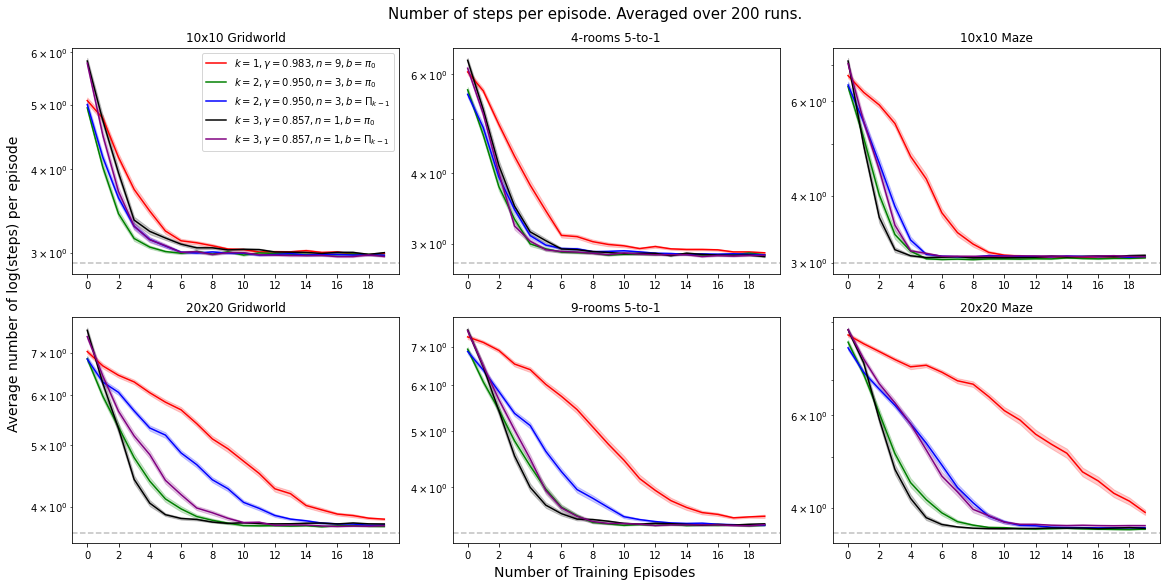

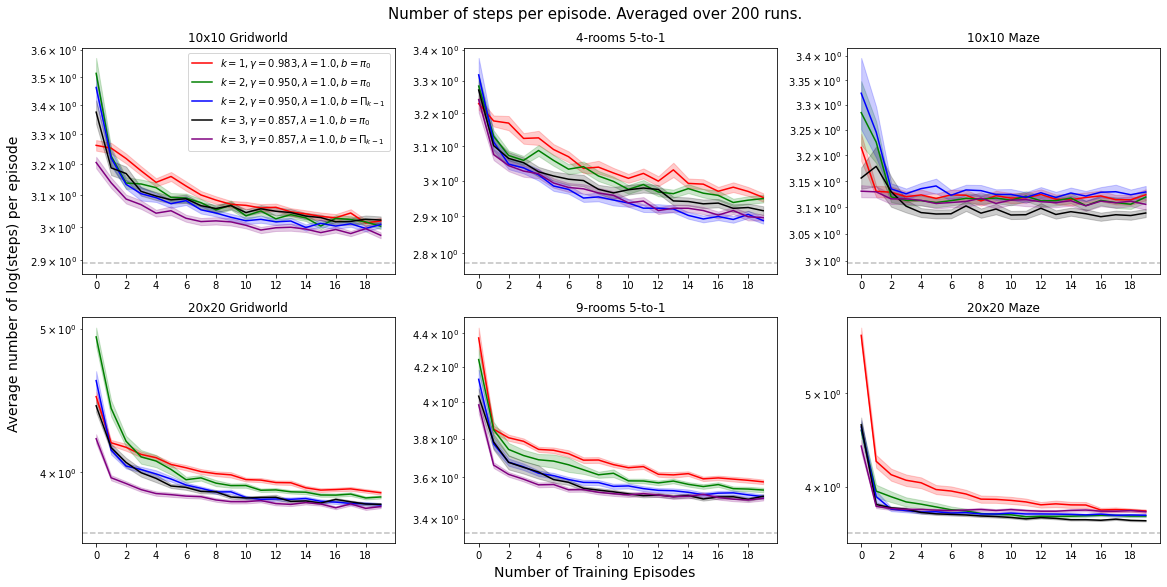

In [40]:
def generate_loss_curve(file_anno: str, annotate: bool = True):    
    # Create two figures to separately plot the loss curves for the HierTB and HierQ agents 
    fig_n, ax_n = plt.subplots(2, 3, figsize=(16, 8))
    fig_d, ax_d = plt.subplots(2, 3, figsize=(16, 8))
    figs = [fig_n, fig_d]
    
    for env_i, env_data in enumerate(discount_data):
        
        # Environment data for generating the graphs.
        meta_lst = [[env_data['meta'][i] for i in n_idx], [env_data['meta'][i] for i in d_idx]]
        
        # Compute Plotting data.
        trajectories = variance_stabilizer(np.asarray(get_timeseries(env_data['data'])))
        trajectories = trajectories[..., :trajectories.shape[-1] - episode_subsample]
        means = trajectories.mean(axis=1)
        stderrs = trajectories.std(axis=1) / np.sqrt(trajectories.shape[1])
    
        # Split for n-step and decay parameters
        mu_n, mu_d = means[n_idx], means[d_idx]
        s_n, s_d = stderrs[n_idx], stderrs[d_idx]
        
        # Select Correct Environment canvas to plot data on.
        canvas_lst = [ax_n[env_i % 2, env_i // 2], ax_d[env_i % 2, env_i // 2]]
        
        # Separate conditional parameters horizontally by padding the x-axis.
        xs = np.arange(trajectories.shape[-1])

        c = ['red', 'green', 'blue', 'black', 'purple'] * 2
        for z, (n_i, d_i) in enumerate(zip(n_idx, d_idx)):
    
            for i, j in enumerate([n_i, d_i]):
                # Extract ablation parameters
                m = meta_lst[i][z]
                b, gamma, k = m['flat_training'], m['discount'], m['n_levels']

                label = fr'$k={k}, \gamma = {gamma:.3f}, '
                label += (fr'\lambda={m["decay"]}' if i else fr'n={m["n_steps"]}') + fr', '
                label += fr'b = ' + (r"\pi_0" if b else r"\Pi_{k-1}") + '$'

                # Plot decay data
                canvas_lst[i].plot(xs, means[j], color=c[z], label=label)
                canvas_lst[i].fill_between(xs, means[j] - stderrs[j], means[j] + stderrs[j], alpha=0.2, color=c[z])

        # Canvas formatting
        for canvas in canvas_lst:
            canvas.set_title(environment_labels[env_i])
            
            # Environment Optimum
            canvas.axhline(variance_stabilizer(environment_optimum[env_i]), 
                           0, 7, color='grey', linestyle='--', alpha=0.5)
            canvas.set_xticks(xs[::2])

            # Canvas plot scaling
            canvas.set_yscale('log')
            
            if env_i == 0:  # Show legend only once on environment-canvas by choice.
                canvas.legend()

    # Plot annotations
    for i, fig in enumerate(figs):
        fig.text(0.5, -0.01, 'Number of Training Episodes', fontsize=14, ha='center')
        fig.text(-0.01, 0.5, 'Average number of log(steps) per episode', fontsize=14, va='center', rotation='vertical')

        fig.suptitle("Number of steps per episode. Averaged over 200 runs.", fontsize=15)

        fig.tight_layout()
        fig.savefig(f'{folder}{file_anno}LossCurve_{"lambda" if i else "n"}.pdf', format='pdf', bbox_inches="tight")


# Omit the last n episodes of the loss curve (if the curves become too flattened; default = 0)
episode_subsample = 30  
variance_stabilizer = lambda x: x
variance_stabilizer = np.log

# Choose how to aggregate the data.
generate_loss_curve("Full")
plt.show()

# Policy Behaviour: First Reward Statistics

In [129]:
from scipy.stats import gamma, expon
import pandas as pd

In [130]:
folder = 'results/ablations/default100k/first_reward/'

episode_data = list()
for e in environment_names:  # The Large environments
    print(e)
    l = [x for x in os.listdir(folder) if e in x]
    if l:
        n = folder + l[-1]
        print(n)
        with open(n, 'rb') as f:
            episode_data += pickle.load(f)

gridworld-v0
results/ablations/default100k/first_reward/t100k_first_reward_ablation_gridworld-v0_1642513872.out
gridworld-v1
results/ablations/default100k/first_reward/t100k_first_reward_ablation_gridworld-v1_1642548860.out
n_rooms-v0
results/ablations/default100k/first_reward/t100k_first_reward_ablation_n_rooms-v0_1642553138.out
n_rooms-v1
results/ablations/default100k/first_reward/t100k_first_reward_ablation_n_rooms-v1_1642569579.out
maze-v0
results/ablations/default100k/first_reward/t100k_first_reward_ablation_maze-v0_1642576407.out
maze-v1
results/ablations/default100k/first_reward/t100k_first_reward_ablation_maze-v1_1642616368.out


In [131]:
print("Data Statistics: (env - data shape - max steps)")
[(x['name'], np.asarray(x['data']).shape, np.asarray(x['data']).max()) for x in episode_data]

Data Statistics: (env - data shape - max steps)


[('gridworld-v0', (32, 200), 10127),
 ('gridworld-v1', (32, 200), 69910),
 ('n_rooms-v0', (32, 200), 14986),
 ('n_rooms-v1', (32, 200), 62214),
 ('maze-v0', (32, 200), 78472),
 ('maze-v1', (32, 200), 98830)]

Check data statistics above! Ensure that the max-steps does not exceed the environment termination time! Otherwise it will be ambiguous whether a reward was observed at all. $\rightarrow$ make $t$ sufficiently large.

## Histograms

The first reward statistics are essentially count-based data. Each data-point indicates a bin $k$ as a sparse representation of having counts for each individual bin.

The histograms below will show that the data approximately resemble of a Gamma distribution. However, in most cases the shape can even be summarized by an Exponential distribution (which is just a Gamma distribution with a shape parameter of $\alpha = 1$).

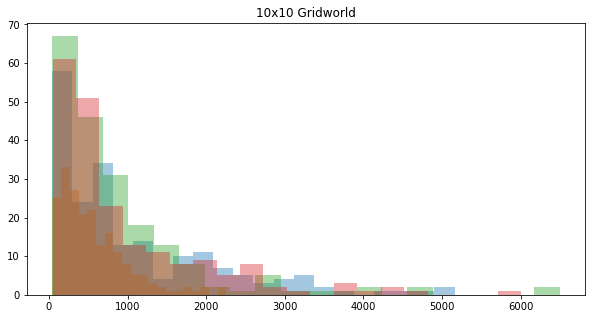

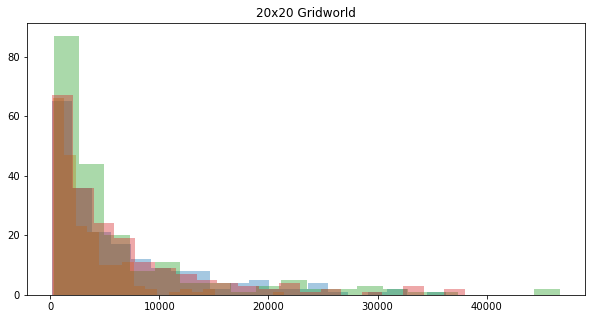

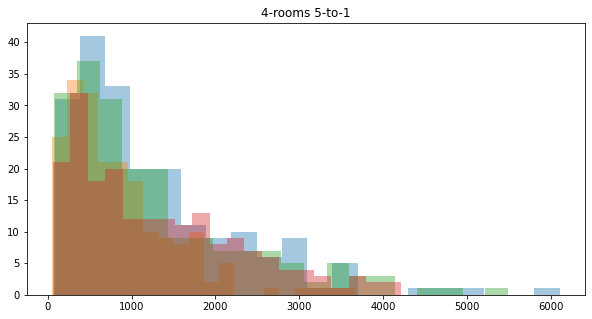

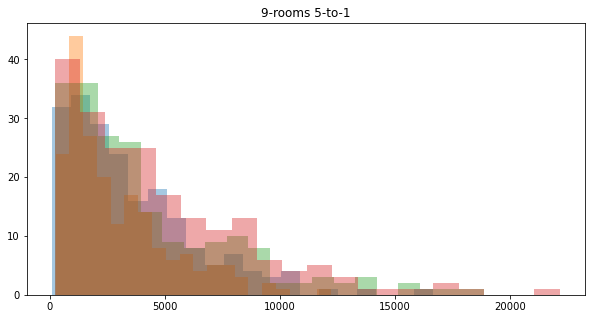

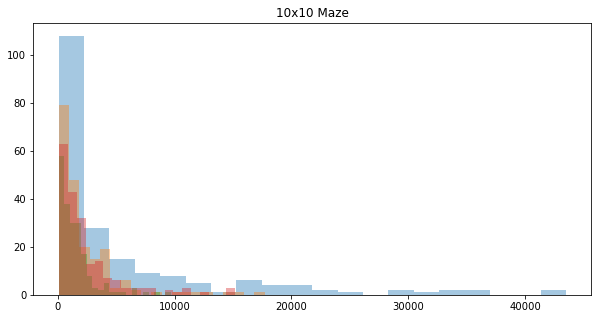

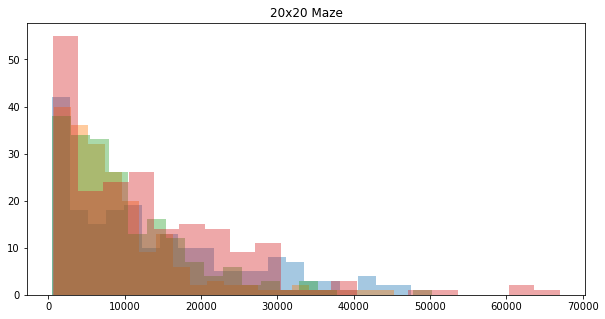

In [132]:
# Investigate Environment indices in 'envs' based on the Boxplot for the 1st episode rewards.
envs = [1, 4]

for i, d in enumerate(episode_data):    
    x = d['data']
    
    subsample = x[14:18]  # Modify the slice for plot clarity.   

    # Create boxplot for episode statistics
    plt.figure(figsize=(10, 5))
    
    for j in subsample:
        plt.hist(j, bins=20, alpha=0.4, orientation='vertical')
        
    plt.title(environment_labels[i])
    plt.show()
    

# Boxplots and MLE

Gaussian MLE
mean: [8405.695 8253.785 6527.785 3300.13  6562.825 8009.955 5176.315 3064.375]
stderr: [788.1789  663.18817 435.88845 189.20601 627.69862 600.34057 394.3099
 209.79304]

Gamma MLE
[0.89164 0.8212  1.0044  1.57562 0.87572 0.88784 0.97002 1.29276]
[ 9384.66002 10004.64386  6461.33422  2070.38304  7450.80672  8979.08798
  5297.11274  2341.01405]

Exponential MLE
[8367.695 8215.785 6489.785 3262.13  6524.825 7971.955 5138.315 3026.375]



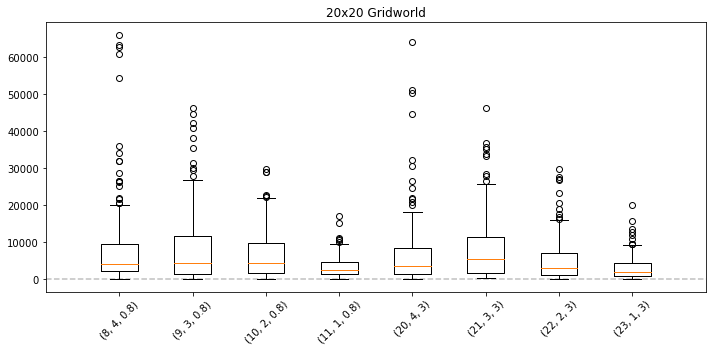

Gaussian MLE
mean: [1663.19  2913.555 6317.945 2524.545 1680.935 2572.65  4999.55  2493.1  ]
stderr: [142.99777 266.74011 665.06547 186.74573 143.48    247.27323 554.6348
 170.70107]

Gamma MLE
[1.04471 0.81773 0.56645 1.04986 1.2002  0.8842  0.67121 1.21289]
[ 1572.8721   3538.51514 11118.24125  2385.59601  1383.88076  2886.95459
  7418.78433  2039.02049]

Exponential MLE
[1643.19  2893.555 6297.945 2504.545 1660.935 2552.65  4979.55  2473.1  ]



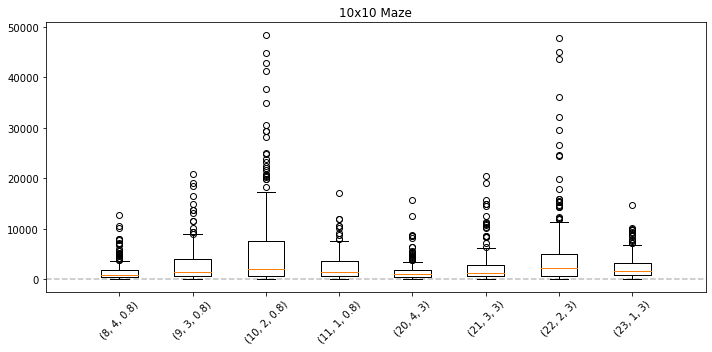

In [135]:
# Investigate Environment indices in 'envs' based on the Boxplot for the 1st episode rewards.
envs = [1, 4]

for i in envs:    
    x = episode_data[i]['data']
    m = episode_data[i]['meta']
    ticks = [(i, x['n_levels'], x['n_steps'] if x['atomic'] else x['decay']) for i, x in enumerate(m)]
    
    # Exemplary slices: [8:12], [20:24]
    x, ticks = x[8:12] + x[20:24], ticks[8:12] + ticks[20:24]    
    x = np.asarray(x)

    # MLE for various distribution assumptions.
    mus, stderr = x.mean(axis=-1), x.std(axis=-1) / np.sqrt(x.shape[-1])
   
    gamma_fit = [gamma.fit(j, floc=environment_optimum[i]) for j in x]
    galpha, _, gscale = list(zip(*gamma_fit)) 
    
    exponential_fit = [expon.fit(j, floc=environment_optimum[i]) for j in x]
    _, escale = list(zip(*exponential_fit))
    
    print("Gaussian MLE")
    print('mean:', np.round(mus, 5))
    print('stderr:', np.round(stderr, 5))
    print()
    print("Gamma MLE")
    print(np.round(galpha, 5))
    print(np.round(gscale, 5))
    print()
    print("Exponential MLE")
    print(np.round(escale, 5))
    print()
    
    # Create boxplot for episode statistics
    plt.figure(figsize=(10, 5))
    
    plt.boxplot(x.T)
    plt.xticks(range(1, 1 + len(ticks)), ticks, rotation=45)
    
    # Environment Optimum
    plt.hlines(environment_optimum[i], 0, len(ticks) + 1, color='grey', linestyle='--', alpha=0.5)
        
    plt.title(environment_labels[i])
    
    plt.xlim([0, len(ticks) + 1])
    plt.tight_layout()
    plt.show()
    

Collect all MLE statistics into a pandas DataFrame for visualization.

In [136]:
env_statistics = list()

for i, d in enumerate(episode_data):    
    x = np.asarray(d['data'])
    m = d['meta']
    
    n_levels = [j["n_levels"] for j in m]
    param = [f'n={j["n_steps"]}' if j["atomic"] else f'lambda={j["decay"]}' for j in m]
    
    # MLE for various distribution assumptions.
    mus, stderr = x.mean(axis=-1), x.std(axis=-1) / np.sqrt(x.shape[-1])

    gamma_fit = [gamma.fit(j, floc=environment_optimum[i]) for j in x]
    galpha, _, gscale = list(zip(*gamma_fit)) 

    exponential_fit = [expon.fit(j, floc=environment_optimum[i]) for j in x]
    _, escale = list(zip(*exponential_fit))
    
    env_mle = {
        'n_levels': n_levels,
        'param': param,
        'loc': [environment_optimum[i]] * len(x),
        'mean': list(mus),
        'stderr': list(stderr),
        'gamma_alpha': list(galpha),
        'gamma_scale': list(gscale),
        'expon_scale': list(escale),
        'min': list(x.min(axis=-1)),
        'max': list(x.max(axis=-1)),
        'median': list(np.median(x, axis=-1).astype(int))
    }
    
    env_statistics.append(env_mle)  
    

with open('first_reward_mle.out', 'wb') as f:
    pickle.dump(env_statistics, f)

In [137]:
with open('first_reward_mle.out', 'rb') as f:
    env_statistics = pickle.load(f)

In [180]:
from IPython.display import display

# Investigate Environment indices in 'envs' based on the Boxplot for the 1st episode rewards.
envs = [1, 4]
# envs = range(len(environment_labels))  # All Envs.

representatives = [8, 9, 10, 11, 20, 21,22, 23]
# representatives = range(len(env_statistics[0]['loc']))  # All data

statistics = [0, 1, 3, 4, 7]
# statistics = range(len(env_statistics[0]))  # All statistics

for i in envs:
    df = pd.DataFrame(env_statistics[i])
    
    print(f"Subsample of 1st Reward Statistics on {environment_labels[i]}")
    display(df.sort_values(['param', 'n_levels']).iloc[representatives, statistics].round(0))

Subsample of 1st Reward Statistics on 20x20 Gridworld


,n_levels,param,mean,stderr,expon_scale
11,1,lambda=0.8,3300.0,189.0,3262.0
10,2,lambda=0.8,6528.0,436.0,6490.0
9,3,lambda=0.8,8254.0,663.0,8216.0
8,4,lambda=0.8,8406.0,788.0,8368.0
23,1,n=3,3064.0,210.0,3026.0
22,2,n=3,5176.0,394.0,5138.0
21,3,n=3,8010.0,600.0,7972.0
20,4,n=3,6563.0,628.0,6525.0


Subsample of 1st Reward Statistics on 10x10 Maze


,n_levels,param,mean,stderr,expon_scale
11,1,lambda=0.8,2525.0,187.0,2505.0
10,2,lambda=0.8,6318.0,665.0,6298.0
9,3,lambda=0.8,2914.0,267.0,2894.0
8,4,lambda=0.8,1663.0,143.0,1643.0
23,1,n=3,2493.0,171.0,2473.0
22,2,n=3,5000.0,555.0,4980.0
21,3,n=3,2573.0,247.0,2553.0
20,4,n=3,1681.0,143.0,1661.0


Formatting of data statistics (mean and std-err) to Latex table for the supplementary material.

In [213]:
# Investigate Environment indices in 'envs' based on the Boxplot for the 1st episode rewards.
envs = [1, 4]
envs = range(len(environment_labels))  # All Envs.

representatives = [8, 9, 11, 20, 21, 23]
representatives = range(len(env_statistics[0]['loc']))  # All data

statistics = [3, 4]
# statistics = range(len(env_statistics[0]))  # All statistics

index = None
dfs = list()
for i in envs:
    df = pd.DataFrame(env_statistics[i])
    
    df_sorted = df.sort_values(['param', 'n_levels'])
    df = df_sorted.iloc[representatives, statistics].round(0)
    index = df_sorted.loc[:, ['param', 'n_levels']]
    
    # Latex string format
    df = df.astype(int).astype(str)
    df = '$' + df.iloc[:,0] + ' \pm ' + df.iloc[:, 1] + '$'
    
    dfs.append(df)
    
full = pd.concat(dfs, axis=1)
full.columns = [x + ' $\mu \pm s^-1$' for x in environment_labels]
full.index = '$' + index.iloc[:, 0] + ', i=' + index.iloc[:, 1].astype(str) + '$'
print(full.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & 10x10 Gridworld \$\textbackslash mu \textbackslash pm s\textasciicircum -1\$ & 20x20 Gridworld \$\textbackslash mu \textbackslash pm s\textasciicircum -1\$ & 4-rooms 5-to-1 \$\textbackslash mu \textbackslash pm s\textasciicircum -1\$ & 9-rooms 5-to-1 \$\textbackslash mu \textbackslash pm s\textasciicircum -1\$ & 10x10 Maze \$\textbackslash mu \textbackslash pm s\textasciicircum -1\$ & 20x20 Maze \$\textbackslash mu \textbackslash pm s\textasciicircum -1\$ \\
\midrule
\$lambda=0.0, i=1\$ &                   \$561 \textbackslash pm 37\$ &                 \$2746 \textbackslash pm 178\$ &                  \$931 \textbackslash pm 56\$ &                \$2556 \textbackslash pm 142\$ &            \$2149 \textbackslash pm 173\$ &            \$9215 \textbackslash pm 599\$ \\
\$lambda=0.0, i=2\$ &                   \$834 \textbackslash pm 63\$ &                 \$5188 \textbackslash pm 380\$ &                 \$1135 \textbackslash pm 66\$ &                \